### Notes to Self:

With just one sample the network simply memorizes the data.  Perhaps with more samples it will generalize better, but the autoencoder does denoise the music from the speech in the training data.

In [5]:
import math
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

%matplotlib inline


In [3]:
def conv16x1(in_planes, out_planes, stride=1):
    "16x1 convolution with padding"
    return nn.Conv1d(in_planes, out_planes, kernel_size=17, stride=stride,
                     padding=8, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv16x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.Hardtanh(min_value=-1, inplace=True)
        self.conv2 = conv16x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride
        self.sizes = []

    def forward(self, x):
        residual = x
        self.sizes.append(x.size())
        out = self.conv1(x)
        self.sizes.append(out.size())
        out = self.bn1(out)
        out = self.relu(out)
        self.sizes.append(out.size())

        out = self.conv2(out)
        out = self.bn2(out)
        self.sizes.append(out.size())

        if self.downsample is not None:
            residual = self.downsample(x)
                
        out += residual
        out = self.relu(out)
        self.sizes.append(out.size())
        #print(self.sizes)

        return out
    
sig = np.random.rand(1,1,16000)
#sig = sig.reshape(1, 16, -1)
inputs = torch.from_numpy(sig).float()
print(inputs.size())

ds1 = nn.Conv1d(64, 64, 1, stride=4)
ds2 = nn.Conv1d(64, 128, 1, stride=2)
ds3 = nn.Conv1d(128, 256, 1, stride=1)
hidden_size = 250
n_layers = 2
gru = nn.GRU(256, hidden_size, n_layers, batch_first=True)

class GRUAutoencoder(nn.Module):
    def __init__(self):
        super(GRUAutoencoder, self).__init__()
        self.conv0 = nn.Conv1d(1, 64, 64, stride=8, padding=28)
        self.hardtanh = nn.Hardtanh()
        self.block1 = BasicBlock(64, 64, 4, downsample=ds1)
        self.block2 = BasicBlock(64, 128, 2, downsample=ds2)
        self.block3 = BasicBlock(128, 256, 1, downsample=ds3)
        self.ds1 = nn.Conv1d(64, 64, 1, stride=4)
        self.ds2 = nn.Conv1d(64, 128, 1, stride=2)
        self.ds3 = nn.Conv1d(128, 256, 1, stride=1)
        self.hidden_size = 250
        self.n_layers = 2
        self.gru = nn.GRU(256, self.hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 64)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs, hidden):
        x = self.conv0(inputs)
        x = self.hardtanh(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), x.size(2), -1)
        #print(x.size(), hidden.size())
        x, hidden = self.gru(x, hidden)
        x = x.contiguous().view(inputs.size(0) * x.size(1), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(inputs.size(1), -1)
        return(x, hidden)
"""
model = nn.Sequential(nn.Conv1d(1, 64, 64, stride=8, padding=28), 
                      nn.Hardtanh(),
                      BasicBlock(64, 64, 4, downsample=ds1), 
                      BasicBlock(64, 128, 2, downsample=ds2),
                      BasicBlock(128, 256, 1, downsample=ds3))
"""

model = GRUAutoencoder()
print(model)


hidden = Variable(torch.zeros(n_layers, 1, 250))
output, hidden = model(Variable(inputs), hidden)
print(output.size(), hidden.size())


torch.Size([1, 1, 16000])
GRUAutoencoder (
  (conv0): Conv1d(1, 64, kernel_size=(64,), stride=(8,), padding=(28,))
  (hardtanh): Hardtanh (min_val=-1, max_val=1)
  (block1): BasicBlock (
    (conv1): Conv1d(64, 64, kernel_size=(17,), stride=(4,), padding=(8,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): Hardtanh (min_val=-1, max_val=1, inplace)
    (conv2): Conv1d(64, 64, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Conv1d(64, 64, kernel_size=(1,), stride=(4,))
  )
  (block2): BasicBlock (
    (conv1): Conv1d(64, 128, kernel_size=(17,), stride=(2,), padding=(8,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
    (relu): Hardtanh (min_val=-1, max_val=1, inplace)
    (conv2): Conv1d(128, 128, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
   

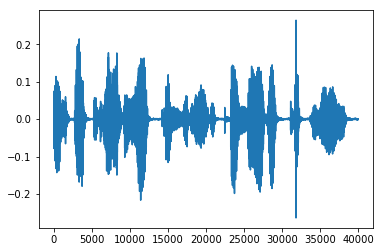

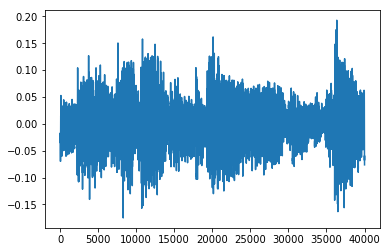

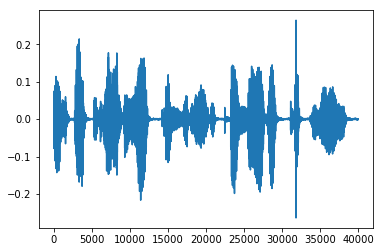

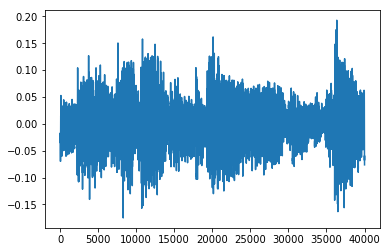

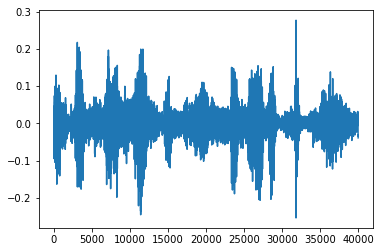

0.254059 0.531067
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0033732596784830093 at epoch 1
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.00273328204639256 at epoch 2
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.00272180768661201 at epoch 3
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0024434351362288 at epoch 4
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0023335465230047703 at epoch 5
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.002254653722047806 at epoch 6
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0021335328929126263 at epoch 7
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0020462165120989084 at epoch 8
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.0019507425604388118 at epoch 9
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.001868566730991006 at epoch 10
torch.Size([25, 1, 1600]) torch.Size([2, 25, 250])
Loss of 0.001772196

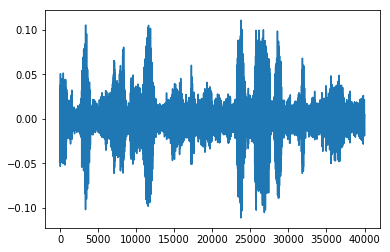

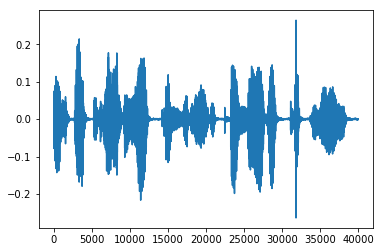

-0.111318 0.110563


In [8]:
import librosa

def plot_tensor_output(t, smin, smax):
    t_plt = unnormalize(t.numpy().ravel().copy(), smin, smax)
    plt.plot(t_plt)
    plt.show()

def unnormalize(sig, smin, smax):
    return((sig * smax) - smin) 


def H_h1(z):
    """
    param z: raw 16-bit PCM signal.  Using z because original paper does so
    return: preprocessed signal with scaling and high-pass filter
    """
    eta = np.random.rand() * 1e-8
    idx = np.where(z == 0)
    z[idx] += eta
    z = (0.46363718 - 0.92724705*(z**-1) + 0.46363718*(z**-2)) / (1 - 1.9059465*(z**-1) + 0.9114024*(z**-2))
    return(z)


model = GRUAutoencoder()
    
files = librosa.util.find_files("pcsnpny-20150204-mkj/wav")
sig, sr = librosa.core.load(files[0], sr=None)
sig = sig[16000:56000]

plt.plot(sig)
plt.show()

sig_noise, _ = librosa.core.load("/home/david/Programming/python/tests/francemusique/cuts/francemusique_037.flac", sr=None)
sig_noise = sig_noise[:40000]

plt.plot(sig_noise)
plt.show()

librosa.output.write_wav("/tmp/sig.wav", sig, sr)
display(Audio("/tmp/sig.wav"))

librosa.output.write_wav("/tmp/noise.wav", sig_noise, sr)
display(Audio("/tmp/noise.wav"))

labels = sig.copy()

sig = sig + sig_noise * 0.5

plt.plot(labels)
plt.show()
plt.plot(sig_noise)
plt.show()
plt.plot(sig)
plt.show()

sig_min_abs = np.abs(sig.min())
sig_max = sig.ptp()

sig += sig_min_abs
sig /= sig_max

labels += sig_min_abs
labels /= sig_max

labels = torch.from_numpy(labels).float()
print(sig_min_abs, sig_max)


sig = sig.reshape(-1, 1, 1600)
sig = torch.from_numpy(sig).float()



epochs = 21

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for epoch in range(epochs):
    model.zero_grad()
    hidden = Variable(torch.zeros(n_layers, sig.size(0), 250))
    inputs = Variable(sig)
    tgts = Variable(labels)
    print(inputs.size(), hidden.size())
    output, hidden = model(inputs, hidden)
    loss = criterion(output, tgts)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch < 10:
        print("Loss of {} at epoch {}".format(loss.data[0], epoch+1))

plot_tensor_output(output.data, sig_min_abs, sig_max)
plot_tensor_output(tgts.data, sig_min_abs, sig_max)


recon = output.data.numpy().ravel().copy()
recon *= sig_max
recon -= sig_min_abs

print(recon.min(), recon.max())

librosa.output.write_wav("/tmp/output.wav", recon, sr)
display(Audio("/tmp/output.wav"))


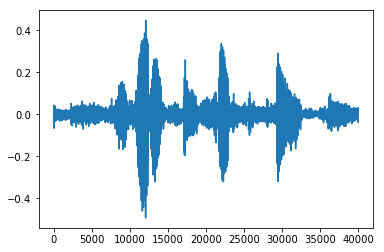

0.493866 0.941101
torch.Size([25, 1, 1600])


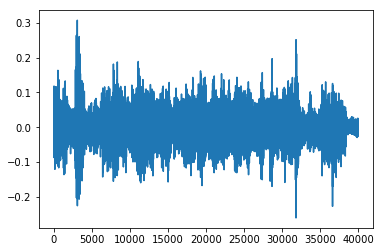

-0.260585 0.307719


In [142]:
sig_test, sr = librosa.core.load(files[1], sr=None)
sig_test = sig_test[16000:56000]

sig_test = sig_test + sig_noise * 0.5

librosa.output.write_wav("/tmp/test.wav", sig_test, sr)
display(Audio("/tmp/test.wav"))
plt.plot(sig_test)
plt.show()

sig_min_abs_test = np.abs(sig_test.min())
sig_max_test = sig_test.ptp()

print(sig_min_abs_test, sig_max_test)

sig_test += sig_min_abs_test
sig_test /= sig_max_test
sig_test *= sig_max

sig_test = sig_test.reshape(-1, 1, 1600)
sig_test = torch.from_numpy(sig_test).float()
print(sig_test.size())

hidden = Variable(torch.zeros(n_layers, sig_test.size(0), 250))
inputs = Variable(sig_test)

output, hidden = model(inputs, hidden)

recon = output.data.numpy().ravel().copy()
recon /= sig_max_test
#recon *= sig_max_test
recon -= recon.mean()

plt.plot(recon)
plt.show()

print(recon.min(), recon.max())

librosa.output.write_wav("/tmp/test_out.wav", recon, sr)
display(Audio("/tmp/test_out.wav"))


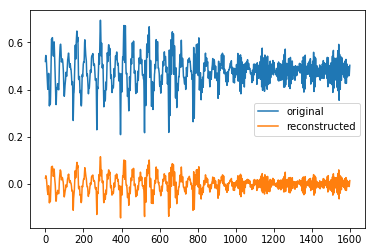

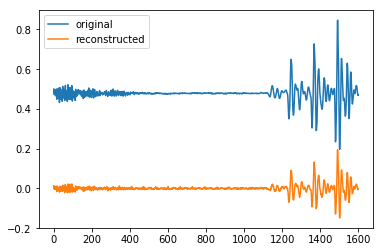

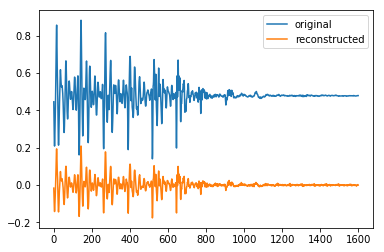

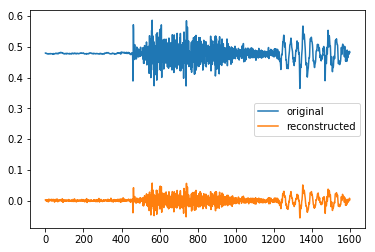

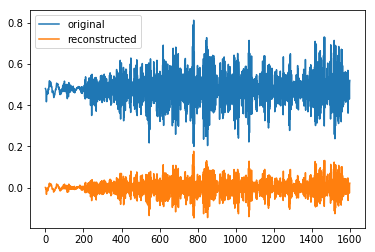

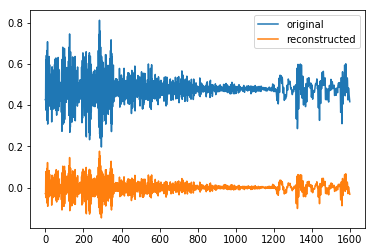

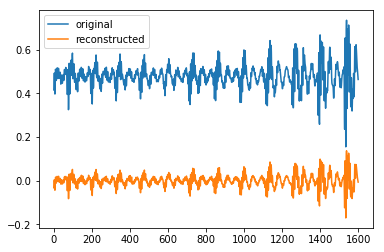

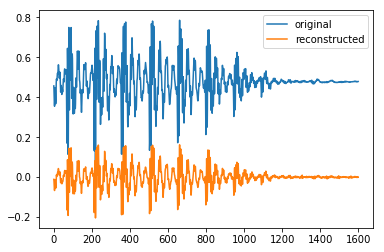

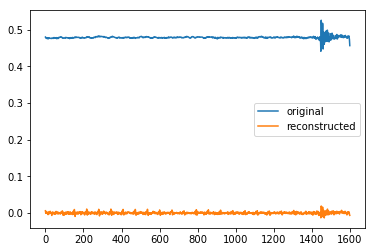

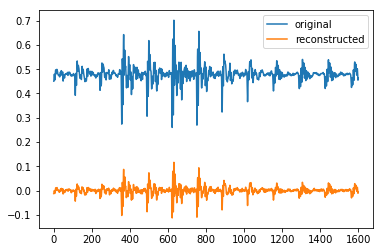

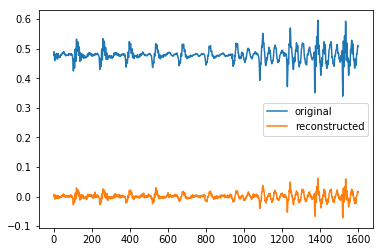

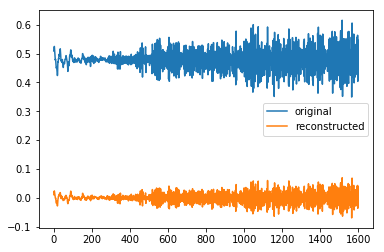

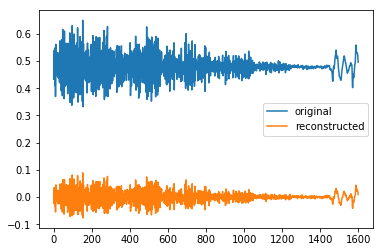

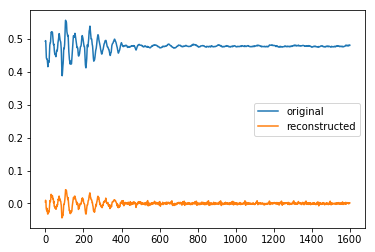

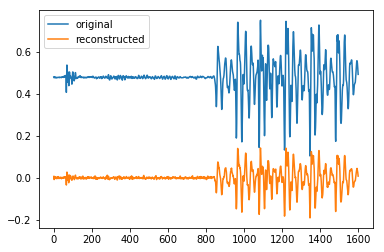

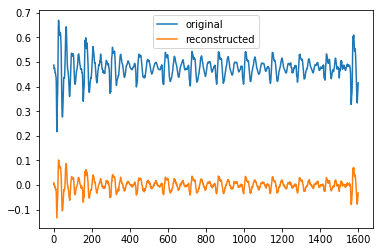

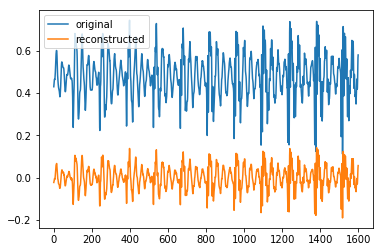

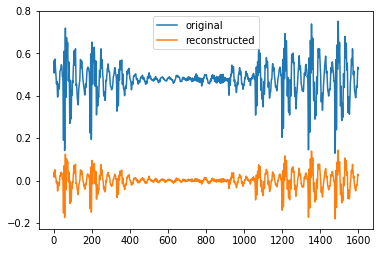

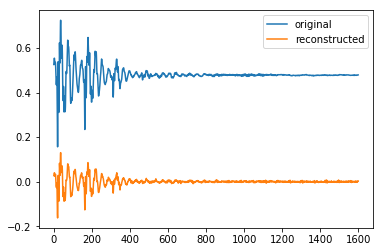

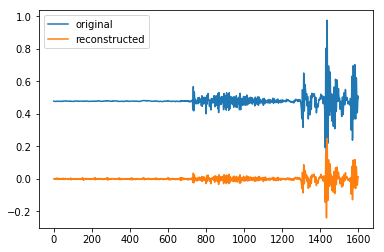

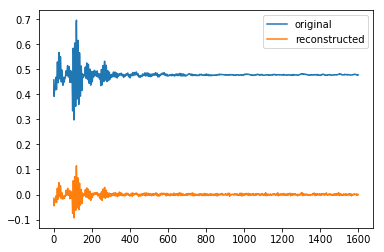

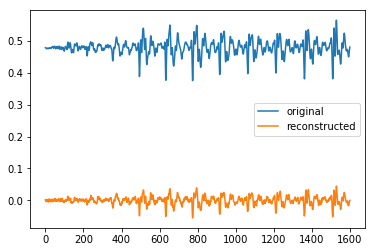

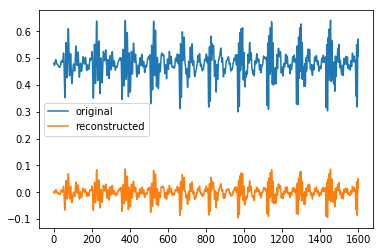

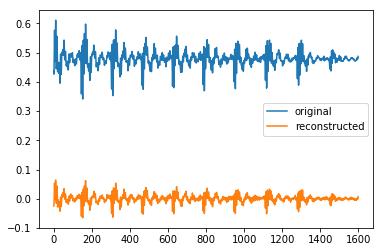

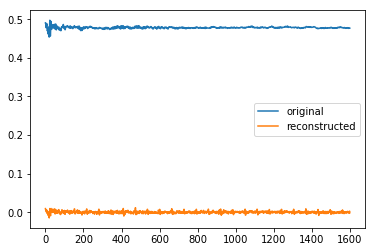

In [149]:
original = labels.numpy().reshape(-1,1,1600)
reconstructed = recon.reshape(-1, 1, 1600)
for s_orig, s_recon in zip(original, reconstructed):
    plt.plot(s_orig.ravel(), label="original")
    plt.plot(s_recon.ravel(), label="reconstructed")
    plt.legend()
    plt.show()
